<a href="https://colab.research.google.com/github/antonionunnally/SQL/blob/main/Danny's_Diner_SQL_Case_Study/Danny's_Diner_SQL_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Danny seriously loves Japanese food so in the beginning of 2021, he decides to embark upon a risky venture and opens up a cute little restaurant that sells his 3 favourite foods: sushi, curry and ramen.

Danny’s Diner is in need of your assistance to help the restaurant stay afloat — the restaurant has captured some very basic data from their few months of operation but have no idea how to use their data to help them run the business.

**Problem Statement**
Danny wants to use the data to answer a few simple questions about his customers, especially about their

*   visiting patterns
*  how much money they’ve spent
*   which menu items are their favourite.

**Table Relationship**

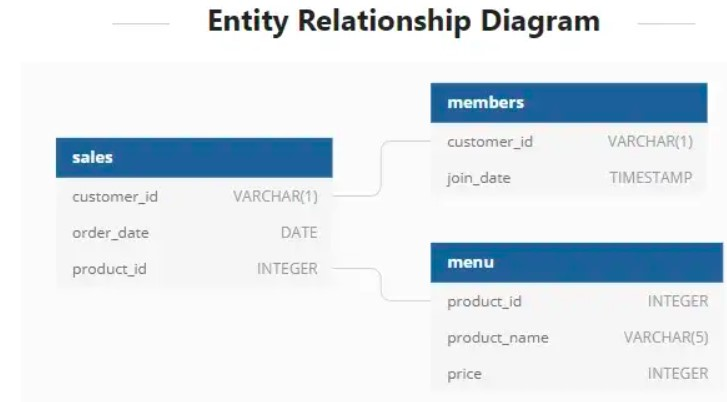


Set Up

In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import sqlite3
print('complete...')

complete...


In [2]:
try:
    conn = sqlite3.connect('danny_diner.db') # # Creates connection to existing db or creates an empty db
    print('Connected successfully...')  
except Exception as e:
    print('Error during connection:', str(e))
else: 
    c = conn.cursor() # # Cursor allows SQL commands to be executed.

Connected successfully...


In [3]:
c.execute( '''
        CREATE TABLE sales (
          "customer_id" VARCHAR(1),
          "order_date" DATE,
          "product_id" INTEGER
        ); ''')

c.execute('''
        INSERT INTO sales
          ("customer_id", "order_date", "product_id")
        VALUES
          ('A', '2021-01-01', '1'),
          ('A', '2021-01-01', '2'),
          ('A', '2021-01-07', '2'),
          ('A', '2021-01-10', '3'),
          ('A', '2021-01-11', '3'),
          ('A', '2021-01-11', '3'),
          ('B', '2021-01-01', '2'),
          ('B', '2021-01-02', '2'),
          ('B', '2021-01-04', '1'),
          ('B', '2021-01-11', '1'),
          ('B', '2021-01-16', '3'),
          ('B', '2021-02-01', '3'),
          ('C', '2021-01-01', '3'),
          ('C', '2021-01-01', '3'),
          ('C', '2021-01-07', '3'); ''')

c.execute('''
        CREATE TABLE menu (
          "product_id" INTEGER,
          "product_name" VARCHAR(5),
          "price" INTEGER
        );''')

c.execute('''
        INSERT INTO menu
          ("product_id", "product_name", "price")
        VALUES
          ('1', 'sushi', '10'),
          ('2', 'curry', '15'),
          ('3', 'ramen', '12'); ''')

c.execute('''     
        CREATE TABLE members (
          "customer_id" VARCHAR(1),
          "join_date" DATE
        );''')

c.execute('''
        INSERT INTO members
          ("customer_id", "join_date")
        VALUES
          ('A', '2021-01-07'),
          ('B', '2021-01-09'); ''')
conn.commit()
print('complete...')

complete...


Table: sales

In [4]:
sales_df = pd.read_sql('''
SELECT * FROM sales''', conn)
print('Table: sales')
sales_df

Table: sales


,customer_id,order_date,product_id
0,A,2021-01-01,1
1,A,2021-01-01,2
2,A,2021-01-07,2
3,A,2021-01-10,3
4,A,2021-01-11,3
5,A,2021-01-11,3
6,B,2021-01-01,2
7,B,2021-01-02,2
8,B,2021-01-04,1
9,B,2021-01-11,1


In [5]:
menu_df = pd.read_sql('''
SELECT * FROM menu''', conn)
print('Table: menu')
menu_df

Table: menu


,product_id,product_name,price
0,1,sushi,10
1,2,curry,15
2,3,ramen,12


1. What is the total amount each customer spent at the restaurant?


In [6]:
customer_total = pd.read_sql('''
SELECT s.customer_id
    , SUM(m.price) AS total
FROM sales s 
JOIN menu m USING(product_id)
GROUP BY s.customer_id;
''', conn)
customer_total

,customer_id,total
0,A,76
1,B,74
2,C,36


2. How many days has each customer visited the restaurant?



In [7]:
customer_visits = pd.read_sql('''
SELECT customer_id
     ,COUNT(DISTINCT order_date) AS visits
FROM sales
GROUP BY customer_id;''', conn)
customer_visits

,customer_id,visits
0,A,4
1,B,6
2,C,2


3. What was the first item from the menu purchased by each customer?



In [8]:
first_item = pd.read_sql('''
SELECT s.customer_id
    , m.product_name
FROM sales s
JOIN menu m USING(product_id)
WHERE s.order_date IN (
    SELECT MIN(order_date)
    FROM sales
    GROUP BY customer_id
   
    );''', conn)
first_item

,customer_id,product_name
0,A,sushi
1,A,curry
2,B,curry
3,C,ramen
4,C,ramen


4. What is the most purchased item on the menu and how many times was it purchased by all customers?



In [9]:
most_purchased = pd.read_sql('''
SELECT m.product_name
    , COUNT(s.product_id) AS purchase_frequency
FROM menu m
JOIN sales s USING(product_id)
GROUP BY s.product_id
ORDER BY s.product_id DESC
LIMIT 1;''', conn)
most_purchased

,product_name,purchase_frequency
0,ramen,8


5. Which item was the most popular for each customer?



In [10]:
popular_item = pd.read_sql('''
WITH cust_pop
AS (
SELECT customer_id
    , product_id
    , COUNT(product_id) AS order_count
FROM sales
GROUP BY customer_id, product_id)

SELECT customer_id
    , product_name
FROM
    (SELECT c.customer_id
        , m.product_name
        , DENSE_RANK() OVER(PARTITION BY customer_id ORDER BY order_count DESC) AS rank
    FROM cust_pop c
    JOIN menu m USING(product_id)) AS fav
WHERE rank = 1;
''',conn)
popular_item

,customer_id,product_name
0,A,ramen
1,B,sushi
2,B,curry
3,B,ramen
4,C,ramen


6. Which item was purchased first by the customer after they became a member?

In [ ]:
first_order_after_memeber = pd.read_sql('''
WITH after_join 
AS (
SELECT s.*
    , mm.*
    , m.product_name
    , DENSE_RANK() OVER(PARTITION BY s.customer_id ORDER BY s.order_date) AS first
FROM sales s
JOIN members mm USING(customer_id)
JOIN menu m ON s.product_id = m.product_id
WHERE s.order_date >= mm.join_date)


SELECT customer_id
    , product_name
FROM after_join
WHERE first = 1;

''',conn)
first_order_after_memeber

7. Which item was purchased just before the customer became a member?

In [ ]:
pre_member = pd.read_sql('''
WITH last_order_member
AS(
SELECT s.*
    , mm.*
    , m.product_name
    , DENSE_RANK() OVER(PARTITION BY customer_id ORDER BY order_date DESC)AS last
FROM sales s
JOIN members mm USING(customer_id)
JOIN menu m ON s.product_id = m.product_id
WHERE s.order_date < mm.join_date)

SELECT customer_id
    , product_name
FROM last_order_member
WHERE last = 1;


''', conn)
pre_member

8. What is the total items and amount spent for each member before they became a member?

In [ ]:
totals = pd.read_sql('''

SELECT s.customer_id
    , SUM(m.price) AS total_spent
    , COUNT(s.product_id) AS total_items
FROM sales s
JOIN members mm USING(customer_id)
JOIN menu m ON s.product_id = m.product_id
WHERE s.order_date < mm.join_date
GROUP BY s.customer_id

''', conn)
totals

9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier how many points would each customer have?

In [ ]:
cust_pts = pd.read_sql('''
WITH points
AS (
SELECT s.customer_id
    , s.product_id
    , m.price
    , CASE 
        WHEN product_id = 1 THEN price * 20
        ELSE price *10
        END AS points
FROM sales s
JOIN menu m USING(product_id))

SELECT customer_id
    , SUM(points) AS total_points
FROM points
GROUP BY customer_id

;''', conn)
cust_pts

10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [ ]:
total_points = pd.read_sql('''

WITH cust_points 
AS(

SELECT s.customer_id
    , s.order_date
    , mm.join_date
    , DATE(mm.join_date, '+6 day') AS end_promo
    , s.product_id
    , m.price
    , CASE 
        WHEN s.product_id = 1
            THEN m.price * 20 
        WHEN s.product_id != 1 AND 
        (s.order_date BETWEEN mm.join_date AND DATE(mm.join_date,'+6 day'))
            THEN (m.price * 20)
        ELSE m.price * 10
        END AS points
FROM sales s
JOIN members mm USING(customer_id)
JOIN menu m USING(product_id)
WHERE 
    s.order_date <= '2021-01-31'

)

SELECT customer_id
    , SUM(points)  AS total
FROM cust_points
GROUP BY customer_id;
''',conn)

total_points

Bonus: Join all tables!

In [11]:
full_tb = pd.read_sql('''

SELECT s.customer_id
    , s.order_date
    , m.product_name
    , m.price
    , CASE
        WHEN s.order_date < mm.join_date THEN 'N'
        WHEN s.order_date >= mm.join_date THEN 'Y'
        ELSE 'N'
        END AS member
FROM sales s
JOIN menu m USING(product_id)
LEFT JOIN members mm USING(customer_id)

''', conn)
full_tb

,customer_id,order_date,product_name,price,member
0,A,2021-01-01,sushi,10,N
1,A,2021-01-01,curry,15,N
2,A,2021-01-07,curry,15,Y
3,A,2021-01-10,ramen,12,Y
4,A,2021-01-11,ramen,12,Y
5,A,2021-01-11,ramen,12,Y
6,B,2021-01-01,curry,15,N
7,B,2021-01-02,curry,15,N
8,B,2021-01-04,sushi,10,N
9,B,2021-01-11,sushi,10,Y
